In [2]:
from tinyphysics import run_rollout_controller
from controllers.pid import Controller
from skopt import gp_minimize
from skopt.space import Real, Integer
import numpy as np

c:\Users\pmazu\Documents\GitHub\controls_challenge\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def optimization_function(params, paths=[26]):
    controller = Controller(params)
    data_paths = [f'./data/{i:05}.csv' for i in paths]
    stored_costs = []
    def rollout(data_paths):
        costs = []
        for data_path in data_paths:
            roll = run_rollout_controller(data_path, controller=controller, model_path='./models/tinyphysics.onnx')
            costs.append(roll[0]['total_cost'])
            if (roll[0]['total_cost'] > 200):
                print("High error on ", data_path)
        cost = np.mean(costs)
        return cost
    last_cost = rollout(data_paths)
    stored_costs.append(last_cost)
    # if (last_cost <= 1000):
    #     print("params", params)
    #     data_paths = [f'./data/{i:05}.csv' for i in range(0, 50)]
    #     last_cost = rollout(data_paths)
    #     stored_costs.append(last_cost) 
    print(stored_costs)
    return np.mean(stored_costs)

In [5]:
        # self.v_x0 = params[0]
        # self.alpha_0 = params[1]
        # self.K_alpha = params[2]
        # self.K_p = params[3]
        # self.K_d = params[4]
space = [
    Integer(0, 10, name='v_x0'),
    Real(0.1, 1000, name='alpha_0'),
    Real(0, 1000, name='K_alpha'),
    Real(0.0, 2000, name='K_p'),
    Real(-1, 2000, name='K_d'),
    Real(0.01, 1, name='C'),
    # Real(1, 10, name='R_s'),
    # Real(0, 100000, name='L'),
    # Integer(1, 50, name='d_k'),
]
pid_space = [
    Real(0.0, 10, name='K_p'),
    Real(0.0, 0.0000001, name='K_i'),
    Real(-10, 10, name='K_d'),
]
# res = gp_minimize(optimization_function, space, n_calls=300, random_state=42, verbose=True)
initial_point = [0.3, 0, -0.1]
pairs = []
for i in range(30):
    res = gp_minimize(lambda y: optimization_function(y, paths=[i]), pid_space, n_calls=100, random_state=42, verbose=True, x0=initial_point)
    pairs.append((i, res))
print(pairs)


Iteration No: 1 started. Evaluating function at provided point.
High error on  ./data/00000.csv
[1139.5005568908382]
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.4156
Function value obtained: 1139.5006
Current minimum: 1139.5006
Iteration No: 2 started. Evaluating function at random point.


In [19]:
res

          fun: 70.02935825716644
            x: [0.2269300227092194, 0.11078741887302469, -0.15138213360575925]
    func_vals: [ 8.891e+01  4.531e+04 ...  7.350e+01  7.697e+01]
      x_iters: [[0.3, 0.05, -0.1], [7.965429868602331, 1.8343478986616382, 5.59382000545539], [5.968501579464871, 4.4583275285359125, -8.000501683639943], [4.592488919658672, 3.337086111390219, -7.1426636415611835], [6.50888472948853, 0.5641157902710027, 4.439975445336497], [9.385527090157504, 0.007787658410143285, 9.844231185824356], [6.174815096277166, 6.11653160488281, -9.858673895605651], [0.2306242504141576, 5.247746602583892, -2.002780565694888], [0.4666566321361543, 9.737555188414595, -5.3445731913939145], [0.9060643453282081, 6.183860093330874, -2.3507601746567435], [9.832308858067885, 4.667628932479801, 7.198808134726416], [0.0, 0.0, 10.0], [10.0, 0.0, -10.0], [0.0, 0.0, -10.0], [0.3520844982592794, 0.01207208351405832, 0.0006579449475196952], [0.388117520926409, 0.0, 0.07293546160450681], [0.2522731752

In [22]:
sum = 0
for i in range(len(pairs)):
    if (pairs[i][1].fun < 200):
        sum += pairs[i][1].fun
print(sum / len(pairs))


58.84248261392709


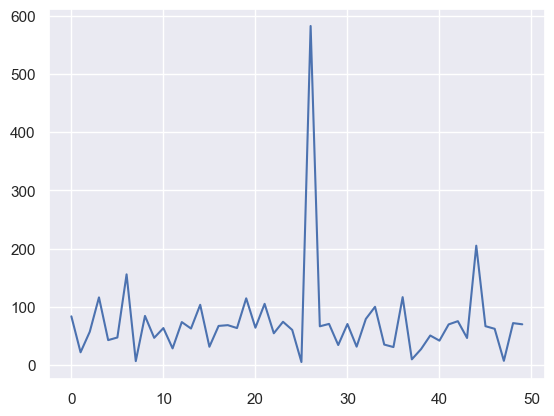

582.1198182408126


In [23]:
# plot error per file
import matplotlib.pyplot as plt
plt.plot([pair[1].fun for pair in pairs])
plt.show()

print(max([pair[1].fun for pair in pairs]))

In [24]:
print(max([pair[1].fun for pair in pairs]))
print("max index: ", [pair[1].fun for pair in pairs].index(max([pair[1].fun for pair in pairs])))


582.1198182408126
max index:  26


In [1]:
pairs[26][1].x

NameError: name 'pairs' is not defined

In [26]:
# see if theres a correlation between the index and the params
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
df = pd.DataFrame(columns=['index', 'v_x0', 'alpha_0', 'K_alpha', 'K_p', 'K_d'])
for i in range(len(pairs)):
    params = pairs[i][1].x
    df = pd.concat([df, pd.DataFrame(index=[i], data={'index': i, 'v_x0': params[0], 'alpha_0': params[1], 'K_alpha': params[2], 'K_p': params[3], 'K_d': params[4]})], ignore_index=False)

IndexError: list index out of range

In [21]:
df.head()

,index,v_x0,alpha_0,K_alpha,K_p,K_d
0,0,8,397.815103,201.025012,1118.713249,68.857297
1,1,6,832.992647,177.330654,739.057147,35.620148
2,2,2,540.944621,207.134434,1154.970194,45.042379
3,3,6,987.718313,265.609615,788.627660,308.856451
4,4,8,920.645872,597.715663,599.060751,383.658415


(array([ 4.,  2.,  4.,  3.,  3.,  3.,  9.,  4.,  6., 12.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

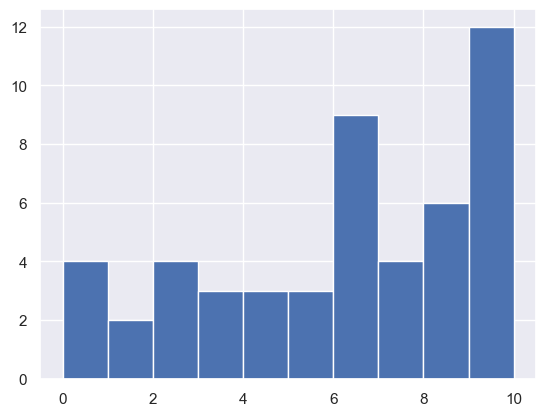

In [22]:
# view distribution of each param
plt.hist(df['v_x0'], bins=10)

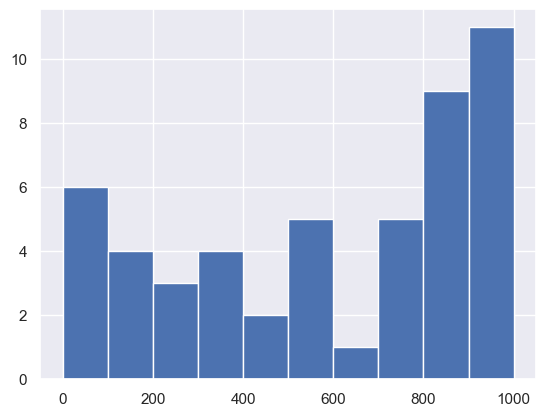

In [23]:
plt.hist(df['alpha_0'], bins=10)
plt.show()

(array([23.,  4.,  1.,  1.,  3.,  3.,  2.,  1.,  2., 10.]),
 array([ 149.91791104,  234.92611993,  319.93432883,  404.94253773,
         489.95074662,  574.95895552,  659.96716442,  744.97537331,
         829.98358221,  914.9917911 , 1000.        ]),
 <BarContainer object of 10 artists>)

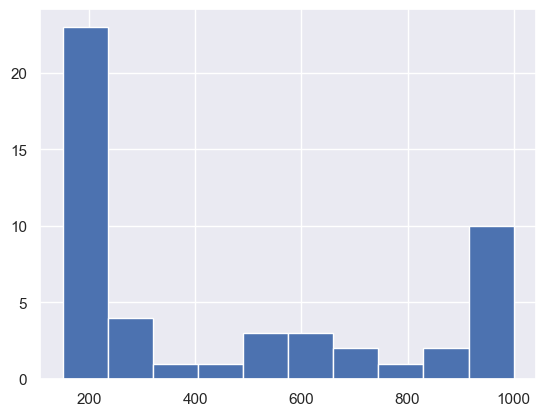

In [24]:
plt.hist(df['K_alpha'], bins=10)


(array([ 1.,  0.,  5., 12.,  3., 13.,  3.,  2.,  2.,  9.]),
 array([   2.23501123,  202.01151011,  401.78800898,  601.56450786,
         801.34100674, 1001.11750561, 1200.89400449, 1400.67050337,
        1600.44700225, 1800.22350112, 2000.        ]),
 <BarContainer object of 10 artists>)

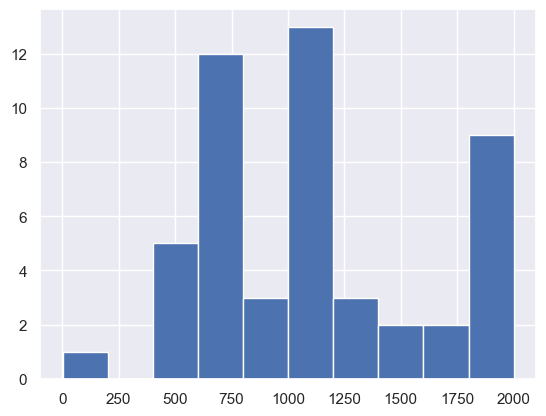

In [25]:
plt.hist(df['K_p'], bins=10)


In [29]:
# add avg speed to each row
for i in range(len(df)):
    data_path = f'./data/{i:05}.csv'
    df_data = pd.read_csv(data_path)
    df.loc[i, 'vEgo'] = df_data['vEgo'].mean()
    # add average alpha
df['avg_alpha'] = df['alpha_0'] + df['K_alpha'] * df['vEgo']
df.head()


,index,v_x0,alpha_0,K_alpha,K_p,K_d,vEgo,avg_alpha
0,0,8,397.815103,201.025012,1118.713249,68.857297,33.612789,7154.826330
1,1,6,832.992647,177.330654,739.057147,35.620148,20.863346,4532.703460
2,2,2,540.944621,207.134434,1154.970194,45.042379,31.195891,7002.687782
3,3,6,987.718313,265.609615,788.627660,308.856451,11.412333,4018.943675
4,4,8,920.645872,597.715663,599.060751,383.658415,10.445296,7163.962908


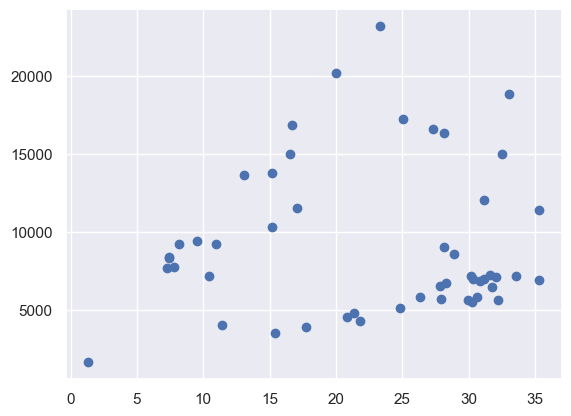

In [30]:
# look at correlation between avg_alpha and vEgo
plt.scatter(df['vEgo'], df['avg_alpha'])

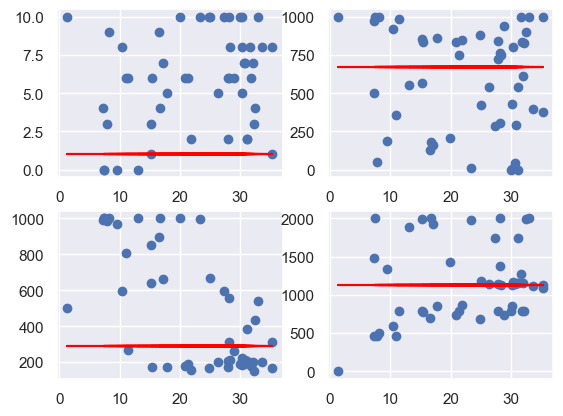

In [27]:
# see if there is a correlation between vEgo and the params
# 4 subplots, graph median lines as well
plt.subplot(2, 2, 1)
plt.scatter(df['vEgo'], df['v_x0'])
plt.plot(df['vEgo'], df['v_x0'].median()-5 * np.ones(len(df)), color='red')
plt.subplot(2, 2, 2)
plt.scatter(df['vEgo'], df['alpha_0'])
plt.plot(df['vEgo'], df['alpha_0'].median() * np.ones(len(df)), color='red')
plt.subplot(2, 2, 3)
plt.scatter(df['vEgo'], df['K_alpha'])
plt.plot(df['vEgo'], df['K_alpha'].median() * np.ones(len(df)), color='red')
plt.subplot(2, 2, 4)
plt.scatter(df['vEgo'], df['K_p'])
plt.plot(df['vEgo'], df['K_p'].median() * np.ones(len(df)), color='red')
plt.show()




In [ ]:
df['alpha_0'].median()

31012.08469890327

In [ ]:
df['K_alpha'].median()

1793.394418071076

In [ ]:
df['K_p'].median()

5550.624198328551

In [ ]:
df['K_d'].median()

10000.0